Download data and put it in place:

In [17]:
# ensure data/ directory exists
!mkdir -p data

# download and extract training data
!wget -nc http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -P data/
!unzip -qn -e data/ml-latest-small.zip -d data/

--2017-09-13 20:07:33--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 918269 (897K) [application/zip]
Saving to: ‘data/ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 896.75K  1.22MB/s    in 0.7s    

2017-09-13 20:07:34 (1.22 MB/s) - ‘data/ml-latest-small.zip’ saved [918269/918269]



In [18]:
from theano.sandbox import cuda

In [19]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

In [20]:
#path = 'data/ml-20m/'
path = 'data/ml-latest-small/'

if not os.path.exists(path):
    os.mkdir(path)

model_path = path + 'models/'
if not os.path.exists(model_path):
    os.mkdir(model_path)
    
batch_size = 64

## Set up data

We're working with the MovieLens data, which contains one rating per row, like this:

In [22]:
ratings = pd.read_csv(path + 'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [23]:
len(ratings)

100004

Just for display purposes, let's read in the moive names too.

In [25]:
movie_names = pd.read_csv(path + 'movies.csv').set_index('movieId')['title'].to_dict()

In [27]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [29]:
userid2idx = {user:index for index, user in enumerate(users)}
movieid2idx = {movie:index for index, movie in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [30]:
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])

In [31]:
user_min, user_max, movie_min, movie_max = (
    ratings.userId.min(), ratings.userId.max(),
    ratings.movieId.min(), ratings.movieId.max(),
)
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [33]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [34]:
n_factors = 50

In [35]:
np.random.seed = 42

Randomly split into training and validation.

In [43]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

array([ True,  True,  True,  True,  True,  True, False, False,  True,  True], dtype=bool)

# Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [46]:
g = ratings.groupby('userId')['rating'].count()
topUsers = g.sort_values(ascending=False)[:15]

In [47]:
g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending=False)[:15]

In [49]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [50]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


# Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [55]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

(671, 50, 9066)

In [66]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse', metrics=['accuracy'])

In [67]:
model.fit(
    [trn.userId, trn.movieId],
    trn.rating,
    batch_size=64,
    nb_epoch=1,
    validation_data=([val.userId, val.movieId], val.rating),
)

Train on 79892 samples, validate on 20112 samples
Epoch 1/1
79892/79892 [==============================] - 4s - loss: 3.2983 - acc: 0.2330 - val_loss: 2.9820 - val_acc: 0.2522


In [68]:
model.optimizer.lr=0.01

In [69]:
model.fit(
    [trn.userId, trn.movieId],
    trn.rating,
    batch_size=64,
    nb_epoch=3,
    validation_data=([val.userId, val.movieId], val.rating),
)

Train on 79892 samples, validate on 20112 samples
Epoch 1/3
79892/79892 [==============================] - 4s - loss: 2.4715 - acc: 0.2764 - val_loss: 2.6732 - val_acc: 0.2697
Epoch 2/3
79892/79892 [==============================] - 4s - loss: 2.2169 - acc: 0.2920 - val_loss: 2.5944 - val_acc: 0.2767
Epoch 3/3
79892/79892 [==============================] - 4s - loss: 2.1171 - acc: 0.3022 - val_loss: 2.5772 - val_acc: 0.2808


In [70]:
model.optimizer.lr=0.001

In [71]:
model.fit(
    [trn.userId, trn.movieId],
    trn.rating,
    batch_size=64,
    nb_epoch=6,
    validation_data=([val.userId, val.movieId], val.rating),
)

Train on 79892 samples, validate on 20112 samples
Epoch 1/6
79892/79892 [==============================] - 4s - loss: 2.0676 - acc: 0.3054 - val_loss: 2.5813 - val_acc: 0.2810
Epoch 2/6
79892/79892 [==============================] - 4s - loss: 2.0380 - acc: 0.3134 - val_loss: 2.5847 - val_acc: 0.2824
Epoch 3/6
79892/79892 [==============================] - 4s - loss: 2.0158 - acc: 0.3186 - val_loss: 2.5930 - val_acc: 0.2851
Epoch 4/6
79892/79892 [==============================] - 4s - loss: 1.9973 - acc: 0.3219 - val_loss: 2.6048 - val_acc: 0.2885
Epoch 5/6
79892/79892 [==============================] - 4s - loss: 1.9802 - acc: 0.3297 - val_loss: 2.6148 - val_acc: 0.2879
Epoch 6/6
79892/79892 [==============================] - 4s - loss: 1.9658 - acc: 0.3371 - val_loss: 2.6324 - val_acc: 0.2842


The (best benchmarks)[http://www.librec.net/example.html] are a bit over 0.9, so this model doesn't seem to be working that well ...

# Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movei and each user, and adding it to our output.

In [72]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [80]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [81]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [82]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [88]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse', metrics=['accuracy'])

In [89]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1,
         validation_data=([val.userId, val.movieId], val.rating))

Train on 79892 samples, validate on 20112 samples
Epoch 1/1
79892/79892 [==============================] - 3s - loss: 2.3463 - acc: 0.2494 - val_loss: 2.1287 - val_acc: 0.2650


In [90]:
model.optimizer.lr = 0.01

In [91]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6,
         validation_data=([val.userId, val.movieId], val.rating))

Train on 79892 samples, validate on 20112 samples
Epoch 1/6
79892/79892 [==============================] - 3s - loss: 1.8241 - acc: 0.2881 - val_loss: 1.9111 - val_acc: 0.2822
Epoch 2/6
79892/79892 [==============================] - 3s - loss: 1.6550 - acc: 0.3036 - val_loss: 1.8164 - val_acc: 0.2906
Epoch 3/6
79892/79892 [==============================] - 3s - loss: 1.5602 - acc: 0.3116 - val_loss: 1.7507 - val_acc: 0.2972
Epoch 4/6
79892/79892 [==============================] - 3s - loss: 1.4844 - acc: 0.3210 - val_loss: 1.6917 - val_acc: 0.2990
Epoch 5/6
79892/79892 [==============================] - 3s - loss: 1.4161 - acc: 0.3264 - val_loss: 1.6372 - val_acc: 0.3026
Epoch 6/6
79892/79892 [==============================] - 3s - loss: 1.3481 - acc: 0.3345 - val_loss: 1.5793 - val_acc: 0.3032


In [92]:
model.optimizer.lr = 0.001

In [93]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10,
         validation_data=([val.userId, val.movieId], val.rating))

Train on 79892 samples, validate on 20112 samples
Epoch 1/10
79892/79892 [==============================] - 3s - loss: 1.2843 - acc: 0.3441 - val_loss: 1.5260 - val_acc: 0.3052
Epoch 2/10
79892/79892 [==============================] - 3s - loss: 1.2207 - acc: 0.3526 - val_loss: 1.4746 - val_acc: 0.3063
Epoch 3/10
79892/79892 [==============================] - 3s - loss: 1.1604 - acc: 0.3618 - val_loss: 1.4243 - val_acc: 0.3067
Epoch 4/10
79892/79892 [==============================] - 3s - loss: 1.1028 - acc: 0.3727 - val_loss: 1.3827 - val_acc: 0.3083
Epoch 5/10
79892/79892 [==============================] - 3s - loss: 1.0497 - acc: 0.3805 - val_loss: 1.3383 - val_acc: 0.3109
Epoch 6/10
79892/79892 [==============================] - 3s - loss: 0.9975 - acc: 0.3912 - val_loss: 1.3032 - val_acc: 0.3118
Epoch 7/10
79892/79892 [==============================] - 3s - loss: 0.9495 - acc: 0.3983 - val_loss: 1.2682 - val_acc: 0.3149
Epoch 8/10
79892/79892 [==============================] - 3s 

In [94]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10,
         validation_data=([val.userId, val.movieId], val.rating))

Train on 79892 samples, validate on 20112 samples
Epoch 1/10
79892/79892 [==============================] - 3s - loss: 0.7872 - acc: 0.4345 - val_loss: 1.1539 - val_acc: 0.3186
Epoch 2/10
79892/79892 [==============================] - 3s - loss: 0.7540 - acc: 0.4412 - val_loss: 1.1324 - val_acc: 0.3207
Epoch 3/10
79892/79892 [==============================] - 3s - loss: 0.7238 - acc: 0.4488 - val_loss: 1.1127 - val_acc: 0.3232
Epoch 4/10
79892/79892 [==============================] - 3s - loss: 0.6968 - acc: 0.4549 - val_loss: 1.0954 - val_acc: 0.3242
Epoch 5/10
79892/79892 [==============================] - 3s - loss: 0.6724 - acc: 0.4617 - val_loss: 1.0795 - val_acc: 0.3255
Epoch 6/10
79892/79892 [==============================] - 3s - loss: 0.6515 - acc: 0.4656 - val_loss: 1.0678 - val_acc: 0.3276
Epoch 7/10
79892/79892 [==============================] - 3s - loss: 0.6323 - acc: 0.4719 - val_loss: 1.0571 - val_acc: 0.3288
Epoch 8/10
79892/79892 [==============================] - 3s 

This result is quite a bit better than the best benchmarks that we could find with a quick goole search - so looks like a great appraoch!

In [96]:
model.save_weights(model_path + 'bias.h5')

In [97]:
model.load_weights(model_path + 'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoyw movie #6:

In [98]:
model.predict([np.array([3]), np.array([6])])

array([[ 4.9134]], dtype=float32)

# Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [99]:
q = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movies bias term. We create a 'model' - which in Keras is simply a way of associating one or more inputs with one or more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [100]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i, b in zip(topMovies, movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch. 

In [101]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.7896511, 'Battlefield Earth (2000)'),
 (-0.60049444, 'Avengers, The (1998)'),
 (-0.41037816, 'Speed 2: Cruise Control (1997)'),
 (-0.39837694, 'Jaws 3-D (1983)'),
 (-0.36841166, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.29738986, 'Bio-Dome (1996)'),
 (-0.26876053, 'Police Academy 6: City Under Siege (1989)'),
 (-0.25468063, 'Batman & Robin (1997)'),
 (-0.24975924, 'Super Mario Bros. (1993)'),
 (-0.21775223, 'Blade: Trinity (2004)'),
 (-0.19139694, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)'),
 (-0.19120233, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.17775352, 'Wild Wild West (1999)'),
 (-0.16758646, 'Little Nicky (2000)'),
 (-0.14945354, 'Howard the Duck (1986)')]

In [102]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.7484493, 'Tom Jones (1963)'),
 (1.7185421, 'Shawshank Redemption, The (1994)'),
 (1.7015635, 'Letters from Iwo Jima (2006)'),
 (1.6436408, 'Cinema Paradiso (Nuovo cinema Paradiso) (1989)'),
 (1.6371335, 'Raise the Red Lantern (Da hong deng long gao gao gua) (1991)'),
 (1.6304016, 'Shadowlands (1993)'),
 (1.6074134, 'Godfather, The (1972)'),
 (1.6045318, 'Top Hat (1935)'),
 (1.5963905, 'Angels and Insects (1995)'),
 (1.5945154, 'October Sky (1999)'),
 (1.59051, 'Treasure of the Sierra Madre, The (1948)'),
 (1.5866902, 'In the Name of the Father (1993)'),
 (1.5825166, 'Philadelphia Story, The (1940)'),
 (1.5756084, 'Harry Potter and the Half-Blood Prince (2009)'),
 (1.5731072, 'Harvey (1950)')]

We can no do the same thing for the embeddings.

In [103]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use (PCA)[https://plot.ly/ipython-notebooks/principal-component-analysis/] to simplify them down to just 3 vectors.

In [104]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [105]:
fac0 = movie_pca[0]

In [106]:
movie_comp = [(f, movie_names[movies[i]]) for f, i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'

In [107]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.082061229819659687, 'Wallace & Gromit: The Wrong Trousers (1993)'),
 (0.076243846168010387,
  "Amelie (Fabuleux destin d'Am\xc3\xa9lie Poulain, Le) (2001)"),
 (0.075783820837463794, "Schindler's List (1993)"),
 (0.074199717305490992,
  'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (0.073001516221311666, 'Usual Suspects, The (1995)'),
 (0.072283964348921662, 'Lord of the Rings: The Two Towers, The (2002)'),
 (0.071139862047774741,
  'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.070917937338172615, 'Fargo (1996)'),
 (0.070378085646121996, 'Goodfellas (1990)'),
 (0.070003742962750845, 'Alien (1979)')]

In [108]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.053231035874388377, 'Anaconda (1997)'),
 (-0.040121345857895466, 'Showgirls (1995)'),
 (-0.038937019189812544, 'Striptease (1996)'),
 (-0.03859202469342711, 'Ace Ventura: When Nature Calls (1995)'),
 (-0.034483481179826338, 'Son in Law (1993)'),
 (-0.031365131937143548, 'Armageddon (1998)'),
 (-0.030710010899868367, 'X-Men Origins: Wolverine (2009)'),
 (-0.029762841168005472, 'RoboCop 3 (1993)'),
 (-0.028813860885724935, 'Barb Wire (1996)'),
 (-0.028507627280405071, 'Eraser (1996)')]

In [111]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[movies[i]]) for f, i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [112]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.10476398955047196, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.098539589522737545, 'Armageddon (1998)'),
 (0.089264061727176006, 'Braveheart (1995)'),
 (0.087504902612753954, 'Speed (1994)'),
 (0.086156418856792441, 'Stargate (1994)'),
 (0.085198329780732079, 'Ghost (1990)'),
 (0.083372845005956486, 'Titanic (1997)'),
 (0.078885189659009744, 'Jurassic Park (1993)'),
 (0.073493083674456089, 'Star Trek: First Contact (1996)'),
 (0.07236373073578857, 'Con Air (1997)')]

In [113]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.061976181441495734, 'Brokeback Mountain (2005)'),
 (-0.053266231841187069, '8 1/2 (8\xc2\xbd) (1963)'),
 (-0.053056644674909816, 'Clockwork Orange, A (1971)'),
 (-0.052789924669148822, 'Vertigo (1958)'),
 (-0.051678177169033758, 'Manhattan (1979)'),
 (-0.051557858548468088,
  "Amelie (Fabuleux destin d'Am\xc3\xa9lie Poulain, Le) (2001)"),
 (-0.049440025896045223, 'Apocalypse Now (1979)'),
 (-0.048923966484826248, 'American Psycho (2000)'),
 (-0.048399326831275881, 'Chinatown (1974)'),
 (-0.048383888414438143, 'Lost in Translation (2003)')]

In [114]:
fac2 = movie_pca[2]
movie_comp = [(f, movie_names[movies[i]]) for f, i in zip(fac2, topMovies)]

The 3rd is 'violent vs. happy'.

In [115]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.10651719741199159, 'Beauty and the Beast (1991)'),
 (0.095491413953435633, 'Babe (1995)'),
 (0.079352986353918506,
  'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (0.076285284844863258, "Bug's Life, A (1998)"),
 (0.073789578908001252, 'Shrek (2001)'),
 (0.071988748727074447, 'While You Were Sleeping (1995)'),
 (0.071547161522204111, 'Chicken Run (2000)'),
 (0.07009673109804683, 'Sleepless in Seattle (1993)'),
 (0.069952101051359211, 'Toy Story 2 (1999)'),
 (0.068302460727844141, 'Sabrina (1995)')]

In [116]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.10694319677595555, 'Seven (a.k.a. Se7en) (1995)'),
 (-0.093215869546446756, 'American Psycho (2000)'),
 (-0.0880543810798885,
  'Interview with the Vampire: The Vampire Chronicles (1994)'),
 (-0.087879715208429673, 'Office Space (1999)'),
 (-0.087001360254219798, 'Nightmare Before Christmas, The (1993)'),
 (-0.086308341684612183, 'Kill Bill: Vol. 1 (2003)'),
 (-0.084682934149121675, 'Happy Gilmore (1996)'),
 (-0.083975243118419182, 'Eyes Wide Shut (1999)'),
 (-0.082001776403205232, 'Back to the Future Part II (1989)'),
 (-0.080775752042784893, 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [117]:
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr

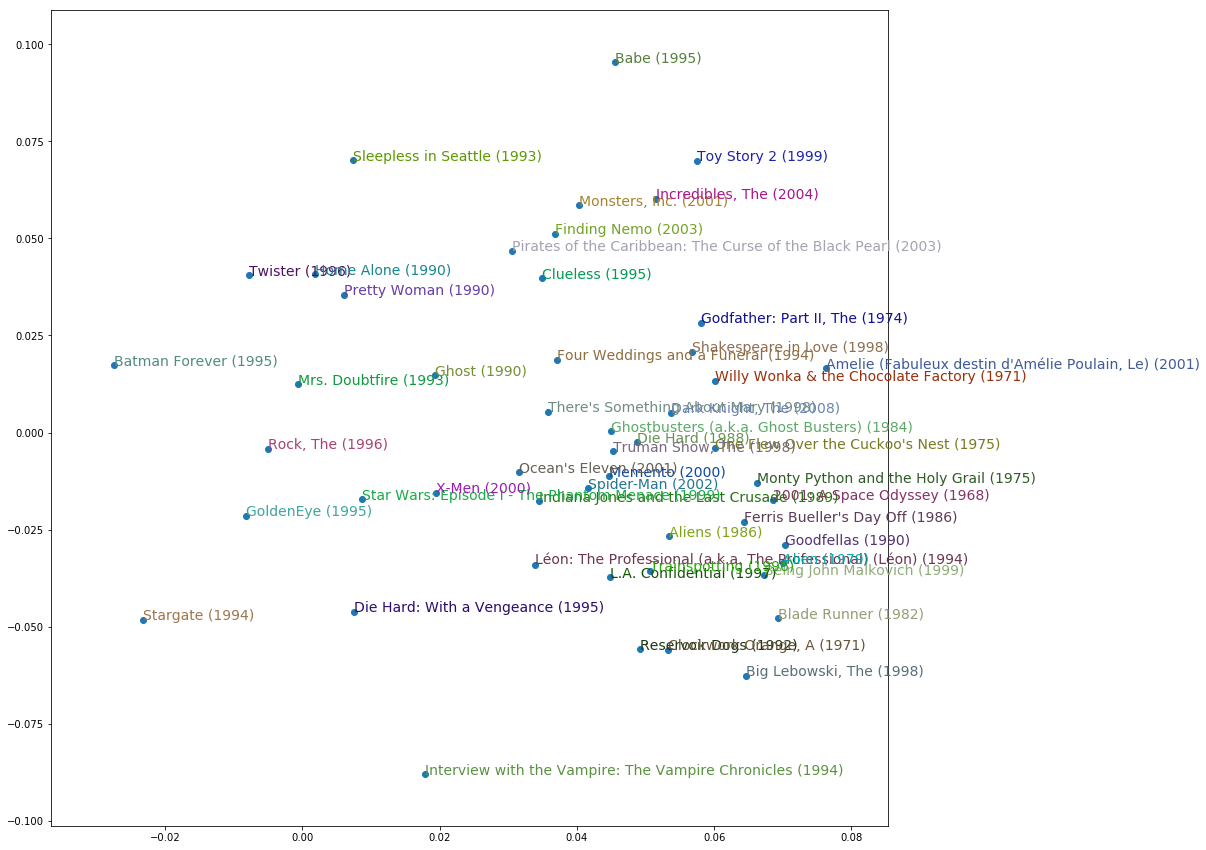

In [120]:
start = 50
end = 100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15, 15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x, y, movie_names[movies[i]], color=np.random.rand(3) * 0.7, fontsize=14)
plt.show()

# Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [121]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

0.0001

In [123]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse', metrics=['accuracy'])

In [126]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8,
      validation_data=([val.userId, val.movieId], val.rating))

Train on 79892 samples, validate on 20112 samples
Epoch 1/8
79892/79892 [==============================] - 4s - loss: 2.3629 - acc: 0.1978 - val_loss: 0.8814 - val_acc: 0.2983
Epoch 2/8
79892/79892 [==============================] - 4s - loss: 1.4271 - acc: 0.2355 - val_loss: 0.8930 - val_acc: 0.2955
Epoch 3/8
79892/79892 [==============================] - 4s - loss: 1.2045 - acc: 0.2619 - val_loss: 0.8778 - val_acc: 0.3048
Epoch 4/8
79892/79892 [==============================] - 4s - loss: 1.0335 - acc: 0.2844 - val_loss: 0.8559 - val_acc: 0.3176
Epoch 5/8
79892/79892 [==============================] - 4s - loss: 0.9199 - acc: 0.3047 - val_loss: 0.8398 - val_acc: 0.3274
Epoch 6/8
79892/79892 [==============================] - 4s - loss: 0.8481 - acc: 0.3205 - val_loss: 0.8367 - val_acc: 0.3342
Epoch 7/8
79892/79892 [==============================] - 4s - loss: 0.8233 - acc: 0.3314 - val_loss: 0.8349 - val_acc: 0.3349
Epoch 8/8
79892/79892 [==============================] - 4s - loss: 

This imporves on our already impressive accuracy even further!